### We have selected 13 stations because there are 13 instead of 12 (as you have wrote) stations that were active before 1950 and still active.

In [22]:
import geopandas as gpd

In [2]:
# The topic of interest
topic_dir = "/annual/kl/recent/"
print("Subdirectory on FTP Server:", topic_dir)

Subdirectory on FTP Server: /annual/kl/recent/


In [3]:
#local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [5]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/recent/
data/original/DWD//annual/kl/recent/

data/generated/DWD/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/


In [6]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [7]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (topic) of concern
ftp_dir =  ftp_climate_data_dir + topic_dir
print("Absolte FTP directory path with data of concern:", ftp_dir)

Absolte FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/


In [8]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [9]:
ret = ftp.cwd(".")

In [10]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

In [11]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [12]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [13]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,239581,-
1,44,jahreswerte_KL_00044_akt.zip,.zip,14881,-
2,71,jahreswerte_KL_00071_akt.zip,.zip,14132,-
3,73,jahreswerte_KL_00073_akt.zip,.zip,15757,-
4,78,jahreswerte_KL_00078_akt.zip,.zip,11671,-
5,91,jahreswerte_KL_00091_akt.zip,.zip,11753,-
6,96,jahreswerte_KL_00096_akt.zip,.zip,13273,-
7,102,jahreswerte_KL_00102_akt.zip,.zip,11813,-
8,125,jahreswerte_KL_00125_akt.zip,.zip,4691,-
9,131,jahreswerte_KL_00131_akt.zip,.zip,12691,-


In [14]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
44,jahreswerte_KL_00044_akt.zip,.zip,14881,-
71,jahreswerte_KL_00071_akt.zip,.zip,14132,-
73,jahreswerte_KL_00073_akt.zip,.zip,15757,-
78,jahreswerte_KL_00078_akt.zip,.zip,11671,-
91,jahreswerte_KL_00091_akt.zip,.zip,11753,-
96,jahreswerte_KL_00096_akt.zip,.zip,13273,-
102,jahreswerte_KL_00102_akt.zip,.zip,11813,-
125,jahreswerte_KL_00125_akt.zip,.zip,4691,-
131,jahreswerte_KL_00131_akt.zip,.zip,12691,-


In [15]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

KL_Jahreswerte_Beschreibung_Stationen.txt


In [16]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt


In [17]:
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["date_from","date_to"], index_col = 0, \
        encoding="latin1")
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [18]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2022-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


In [19]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = (df_stations['state'] == "Nordrhein-Westfalen").values
isActive2021 = (df_stations['date_to'] > "2021").values 
StartedBefore1950 = (df_stations['date_from'] < "1950").values 

# select on both conditions
station_ids_selected = df_stations[isNRW & isActive2021 & StartedBefore1950].index

print(f"Stations located in NRW and still active in 2021: \n{list(station_ids_selected)}")

Stations located in NRW and still active in 2021: 
[555, 1078, 1300, 1303, 1327, 1590, 2110, 2483, 2497, 2629, 2968, 4371, 5717]


In [20]:
df_stations.loc[station_ids_selected].head(13)

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
555,1925-01-01,2023-02-28,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen
1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
1327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
1590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2110,1938-01-01,2022-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
2483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
2497,1937-01-01,2022-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen


In [ ]:
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations['longitude'], df_stations['latitude']), crs='EPSG:4326')

In [ ]:
station_ids_selected = gdf_stations[isNRW & isActive2021 & StartedBefore1950].index

In [32]:
gdf_selected_stations = gdf_stations.loc[station_ids_selected]

In [33]:
gdf_selected_stations = gdf_selected_stations.to_crs('EPSG:25832')

In [34]:
gdf_selected_stations.to_file('selected_stations.gpkg', layer='selected_stations', driver='GPKG')

In [35]:
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_00555_akt.zip
jahreswerte_KL_01078_akt.zip
jahreswerte_KL_01300_akt.zip
jahreswerte_KL_01303_akt.zip
jahreswerte_KL_01327_akt.zip
jahreswerte_KL_01590_akt.zip
jahreswerte_KL_02110_akt.zip
jahreswerte_KL_02483_akt.zip
jahreswerte_KL_02497_akt.zip
jahreswerte_KL_02629_akt.zip
jahreswerte_KL_02968_akt.zip
jahreswerte_KL_04371_akt.zip
jahreswerte_KL_05717_akt.zip


In [36]:
#date_from = '2019-05-01'
#date_to   = '2019-05-31'
date_from = '1700-01-01'
date_to   = '2100-12-31'

In [37]:
import datetime as dt

In [38]:
def prec_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [39]:
def kl_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [40]:
from zipfile import ZipFile
def ts_merge(date_from='1700-01-01', date_to='2100-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [41]:
# df_merged_ts = ts_merge(date_from, date_to)
df_merged_ts = ts_merge(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00555_akt.zip
Extract product file: produkt_klima_jahr_20170101_20211231_00555.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01078_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01078.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01300_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01300.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01303_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01303.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01327_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01327.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01590_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01590.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02110_akt.zip
Extract product file: produkt_klim

In [73]:
import seaborn as sns

In [160]:
#data_path = r"C:/Users/stani/Desktop/EE_3.07_Geodata_WS2022-main/data/original"
data_path = r"../gdms0000_Final_Assignment/data/original"
station_file_name = '/KL_Jahreswerte_Beschreibung_Stationen.txt'

In [161]:
full_fname = data_path + station_file_name
print(full_fname)

../gdms0000_Final_Assignment/data/original/KL_Jahreswerte_Beschreibung_Stationen.txt


In [162]:
#fh = open(full_fanme)
headers = open(full_fname).readline().split()
df_stat = pd.read_fwf(
    full_fname,
    encoding="cp1252",
    skiprows=2,
    names=headers,
    index_col="Stations_id", 
    parse_dates=["von_datum","bis_datum"])
df_stat

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2022-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern
...,...,...,...,...,...,...,...
19364,1937-12-01,1944-12-31,720,50.6167,10.8167,Schmiedefeld/Rennsteig,Thüringen
19378,1958-01-01,1977-12-31,505,50.8333,10.5833,Finsterbergen,Thüringen
19433,1887-01-01,1961-12-31,316,50.8188,10.3443,"Liebenstein, Bad",Thüringen


In [163]:
idx_NRW    = df_stat["Bundesland"] == "Nordrhein-Westfalen"
idx_active = df_stat["bis_datum"]  > "2020-12-31"
idx_early  = df_stat["von_datum"]   < "1950"

In [164]:
df_stat_short = df_stat[idx_NRW & idx_active & idx_early]

In [165]:
df_stat_short

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
555,1925-01-01,2023-01-31,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen
1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
1327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
1590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2110,1938-01-01,2022-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
2483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
2497,1937-01-01,2022-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen


In [166]:
#fname_list = os.listdir('C:/Users/stani/Desktop/EE_3.07_Geodata_WS2022-main/gdms0000_Final_Assignment/data/original')
fname_list = os.listdir('../gdms0000_Final_Assignment/data/original')
#data_path = r"C:/Users/stani/Desktop/EE_3.07_Geodata_WS2022-main/gdms0000_Final_Assignment/data/original"

In [167]:
f_dict={}

for fname in fname_list:
    try:
        key=fname.split("_")[2]
        f_dict[int(key)]=fname
    except:
        print(f"Cannot convert \'{key:s}\' to integer")

n=5
print("Frist {n:d} items of f_dict:")
print({k: f_dict[k] for k in list(f_dict)[:5]})

Cannot convert 'Beschreibung' to integer
Cannot convert 'Beschreibung' to integer
Frist {n:d} items of f_dict:
{555: 'jahreswerte_KL_00555_19250101_20181031_hist.zip', 1078: 'jahreswerte_KL_01078_19400101_20211231_hist.zip', 1300: 'jahreswerte_KL_01300_19310101_20211231_hist.zip', 1303: 'jahreswerte_KL_01303_18880101_20211231_hist.zip', 1327: 'jahreswerte_KL_01327_19370101_20211231_hist.zip'}


In [168]:
zip_list=[]
for k in df_stat_short.index:
    zip_list.append(data_path + f_dict[k])

In [169]:
zip_list = [data_path + '/' + f_dict[k] for k in df_stat_short.index]

In [170]:
zip_list

['../gdms0000_Final_Assignment/data/original/jahreswerte_KL_00555_19250101_20181031_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_01078_19400101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_01300_19310101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_01303_18880101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_01327_19370101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_01590_19370101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_02110_19380101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_02483_19261101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_02497_19370101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahreswerte_KL_02629_18510101_20211231_hist.zip',
 '../gdms0000_Final_Assignment/data/original/jahre

In [171]:
import pandas as pd
import zipfile36

# Very compact code.
df = pd.DataFrame()
for elt in zip_list:
    with ZipFile(elt) as myzip:
        
        # read the time series data from the file starting with "produkt"
        prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
        #print(prodfilename)
        
        # open just the produkt file within the archive
        with myzip.open(prodfilename) as myfile:
            dftmp = pd.read_csv(myfile, sep =";", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], index_col = "MESS_DATUM_BEGINN", na_values = [-999.0])
            # select the series with the average annual temp ("JA_TT"), rename the series with the station_id and make it a df.
            s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"][0]).to_frame()
            # outer merge.
            df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#df.index.names = ["year"]
df.index.rename(name = "year", inplace = True)
df

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1851-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN,NaN,NaN
1852-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN,NaN,NaN
1853-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN,NaN,NaN
1854-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN,NaN,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,10.91,11.43,8.66,10.92,11.14,11.18,11.39,6.26,8.87,NaN,11.92,10.22,10.66
2018-01-01,NaN,12.12,9.24,11.79,11.60,11.86,11.85,7.26,9.49,NaN,12.67,11.05,NaN
2019-01-01,NaN,11.84,9.01,11.44,11.24,11.62,11.42,7.00,9.27,11.17,12.30,10.89,10.99


In [172]:
df.set_index(df.index.year, inplace= True)

In [173]:
df.head()

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN,NaN,NaN
1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN,NaN,NaN


In [174]:
mean = df[(df.index >= 1961) & (df.index <= 1990)].mean() # mean annual temp between 1961 and 1990
mean

555     10.573333
1078    10.387143
1300     7.480000
1303     9.560667
1327     9.636667
1590     9.912222
2110     9.807143
2483     4.847333
2497     7.279310
2629     9.613000
2968    10.780000
4371     9.237333
5717     9.335333
dtype: float64

In [175]:
df_temp_diff = (df - mean)

In [176]:
df_temp_diff

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.883,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.723,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.523,NaN,NaN,NaN
1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.273,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.336667,1.042857,1.18,1.359333,1.503333,1.267778,1.582857,1.412667,1.59069,NaN,1.14,0.982667,1.324667
2018,NaN,1.732857,1.76,2.229333,1.963333,1.947778,2.042857,2.412667,2.21069,NaN,1.89,1.812667,NaN
2019,NaN,1.452857,1.53,1.879333,1.603333,1.707778,1.612857,2.152667,1.99069,1.557,1.52,1.652667,1.654667


In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

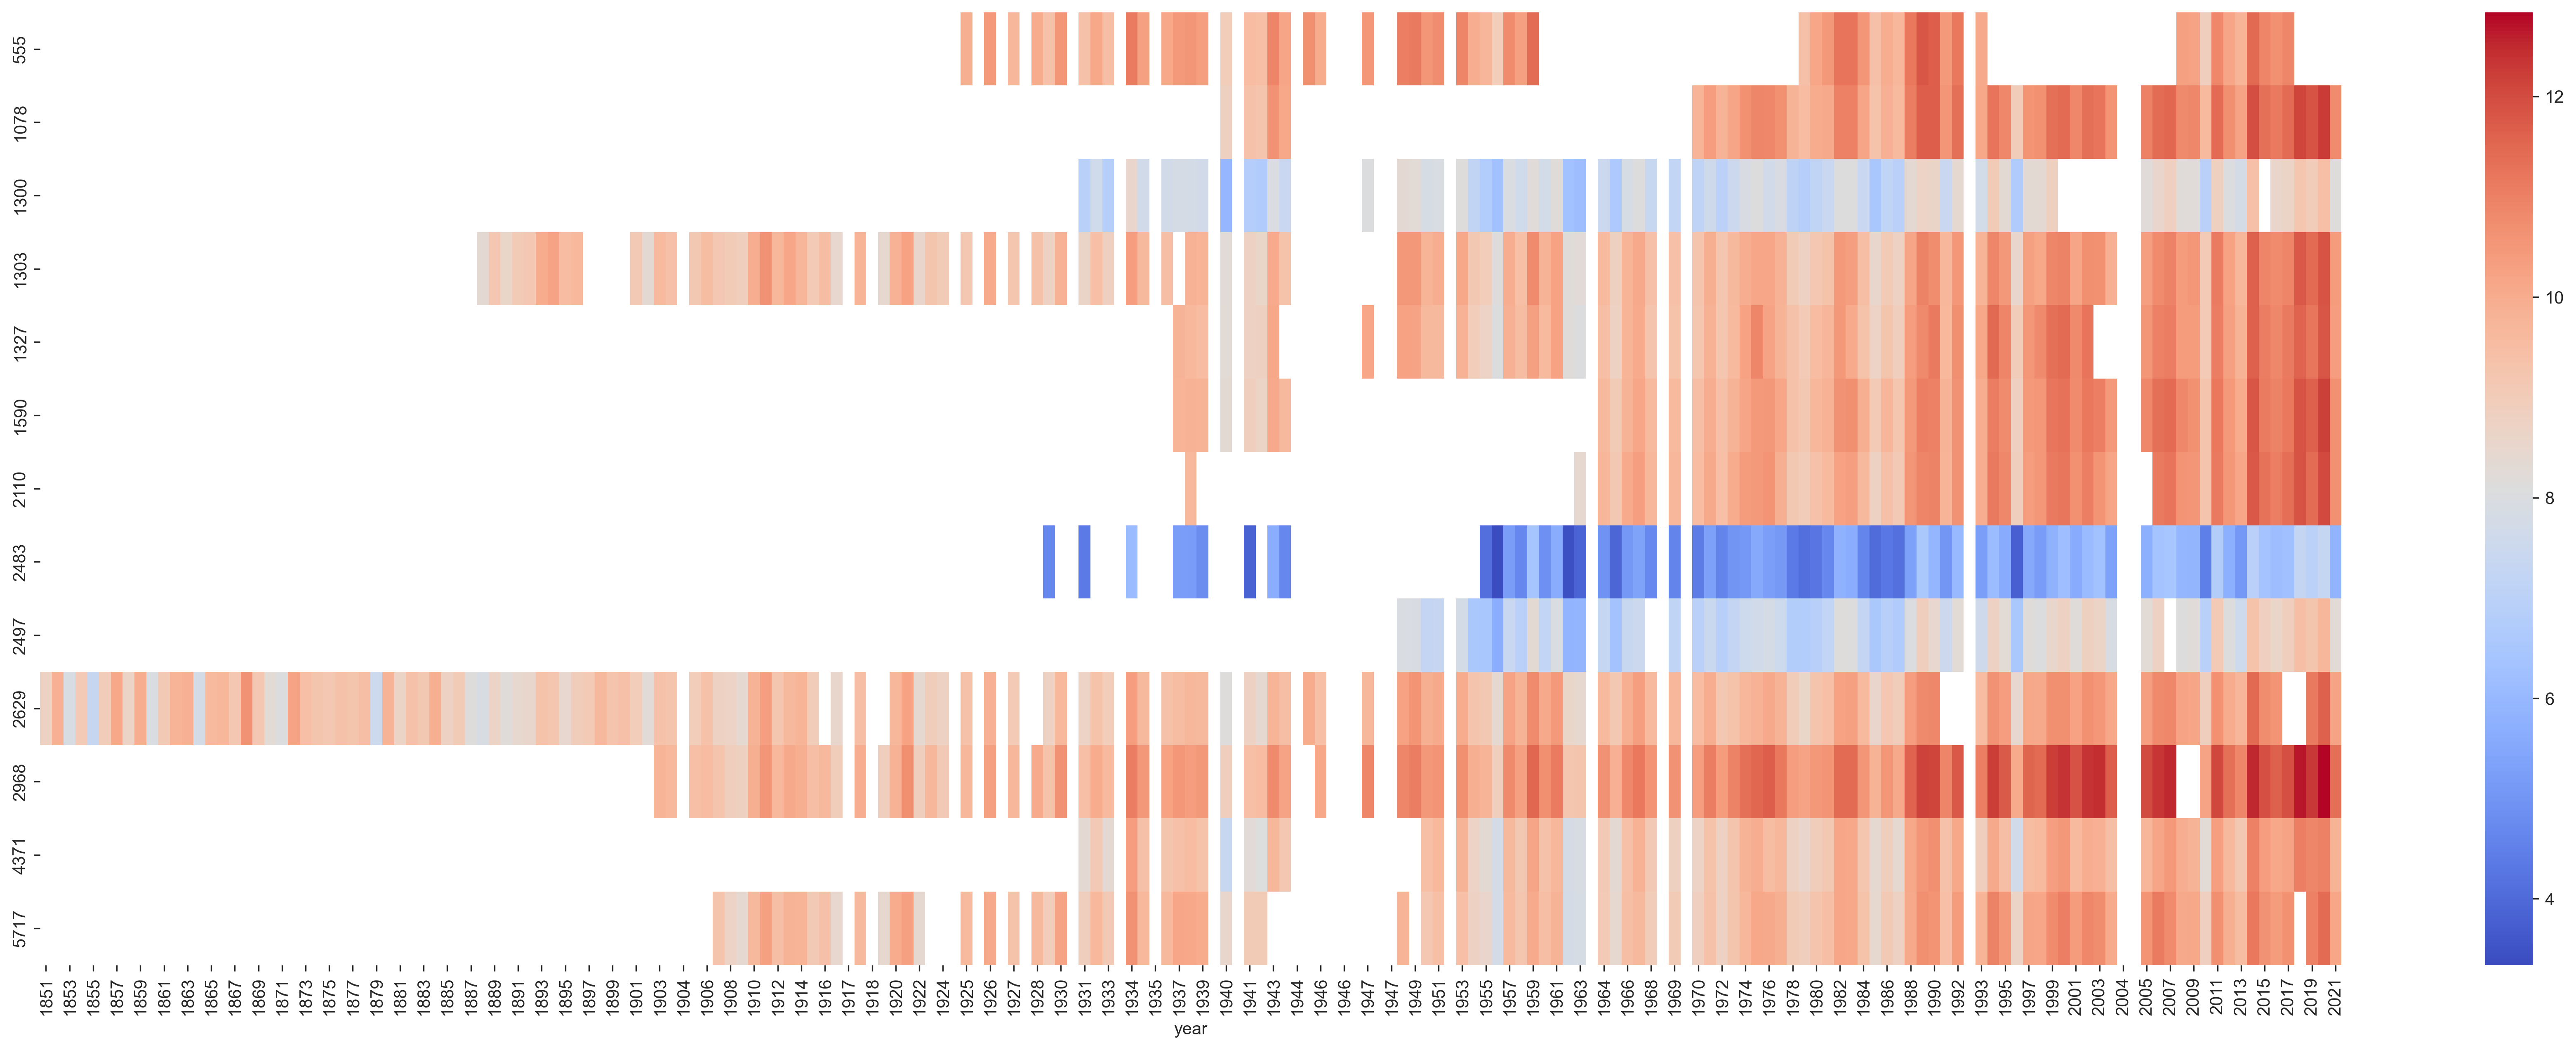

In [178]:
# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

# sns.heatmap(df_temp_diff.T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax4)
sns.heatmap(df.T, cmap='coolwarm', ax = ax1)

fig1.savefig('NRW_Annual_Temp_Stripes_01.png')

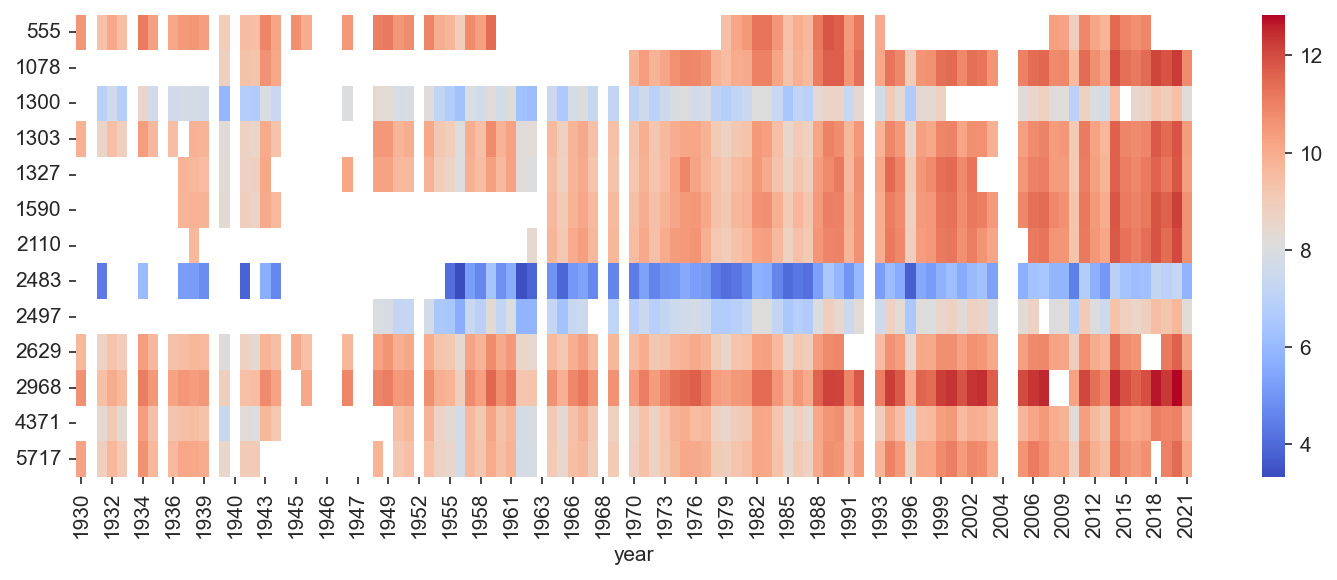

In [179]:
sns.set_style('ticks')
fig2, ax2 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df[df.index >= 1930].T, cmap='coolwarm', ax = ax2)
#ax4.set_xticklabels(df.index.strftime('%Y'))

fig2.savefig('NRW_Annual_Temp_Stripes_02.png')

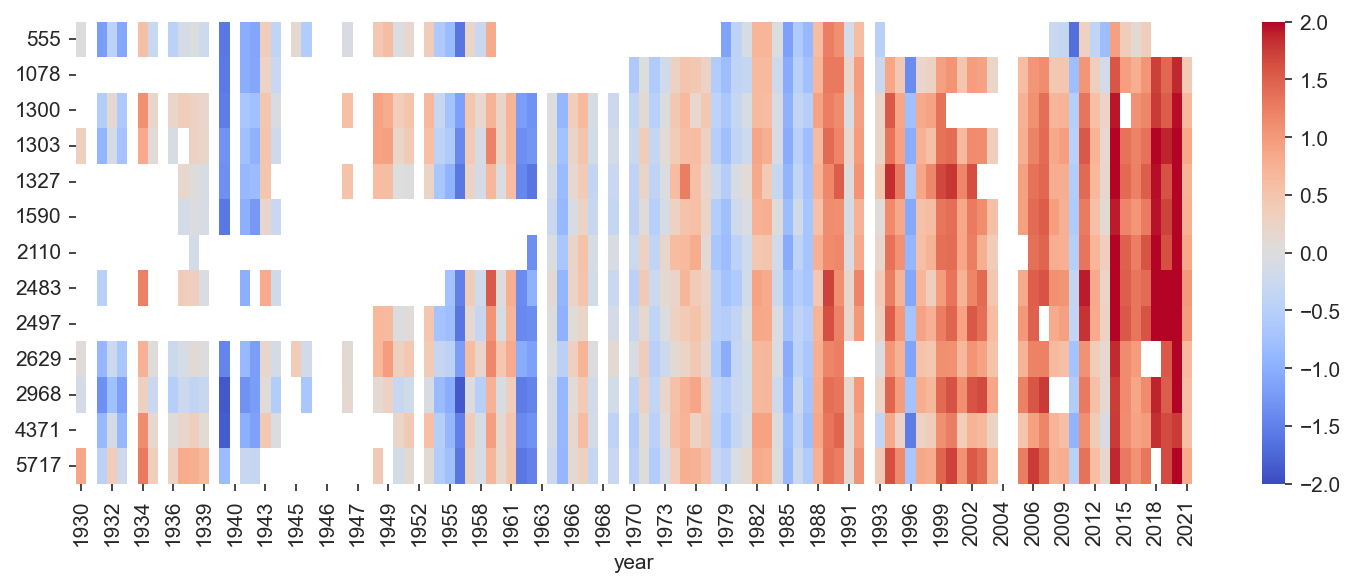

In [180]:
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df_temp_diff[df_temp_diff.index >= 1930].T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax3)
#ax4.set_xticklabels(df.index.strftime('%Y'))

fig3.savefig('NRW_Annual_Temp_Diff_Stripes_02.png')

In [181]:
df_stat_short["Stationsname"]

Stations_id
555                    Bochum
1078               Düsseldorf
1300                   Eslohe
1303           Essen-Bredeney
1327    Weilerswist-Lommersum
1590          Geldern-Walbeck
2110      Heinsberg-Schleiden
2483             Kahler Asten
2497              Kall-Sistig
2629                    Kleve
2968           Köln-Stammheim
4371           Salzuflen, Bad
5717    Wuppertal-Buchenhofen
Name: Stationsname, dtype: object

In [182]:
df_stat_short["von_datum"]

Stations_id
555    1925-01-01
1078   1940-01-01
1300   1931-01-01
1303   1888-01-01
1327   1937-01-01
1590   1937-01-01
2110   1938-01-01
2483   1926-11-01
2497   1937-01-01
2629   1851-01-01
2968   1903-01-01
4371   1931-01-01
5717   1907-01-01
Name: von_datum, dtype: datetime64[ns]

In [183]:
df.head(5)

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN,NaN,NaN
1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN,NaN,NaN
